<a href="https://colab.research.google.com/github/guptamadhav/KilnDrying/blob/main/Kiln_Drying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/guptamadhav/KilnDrying.git

Cloning into 'KilnDrying'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 40 (delta 15), reused 16 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 760.40 KiB | 4.11 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                              classification_report, confusion_matrix, roc_auc_score)

In [22]:
MODELS_DIR  = '/content/KilnDrying/models'
PLOTS_DIR   = '/content/KilnDrying/plots'

In [8]:
data = pd.read_csv('/content/KilnDrying/data_schedules/kiln_drying_dataset.csv')

In [9]:
data.head()

,species,board_size,thickness_mm,density_kg_m3,fiber_saturation_pct,initial_MC_pct,schedule,airflow_m_s,final_MC_pct,total_drying_time_hr,total_energy_kWh,avg_kiln_temp_C,avg_WBD_C,avg_RH_pct,avg_EMC_pct,reached_target,nlga_compliant
0,Fir,2x10,38,471,27.0,73.9,T10-D5,4.20,18.95,28.6,245.9,94.5,23.7,38.4,2.91,1,1
1,Fir,4x4,89,471,27.0,79.2,T10-D5,4.50,18.69,165.9,1384.1,93.5,23.0,39.6,3.03,1,1
2,Pine,4x4,89,512,26.0,94.8,T8-D4,2.87,60.94,209.5,1160.1,65.6,6.5,72.7,7.18,0,0
3,Pine,2x8,38,512,26.0,127.0,T8-D4,4.95,18.76,93.9,593.8,72.0,10.6,63.9,6.11,1,1
4,Pine,2x10,38,512,26.0,107.9,T10-D5,3.69,18.96,52.4,392.0,85.0,17.3,50.4,4.27,1,1


In [10]:
data.describe()

,thickness_mm,density_kg_m3,fiber_saturation_pct,initial_MC_pct,airflow_m_s,final_MC_pct,total_drying_time_hr,total_energy_kWh,avg_kiln_temp_C,avg_WBD_C,avg_RH_pct,avg_EMC_pct,reached_target,nlga_compliant
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,48.200000,462.515000,26.985000,96.944800,3.507370,26.205340,101.803700,628.913900,75.662100,12.617600,59.498500,5.541130,0.813000,0.49000
std,20.410208,45.264983,0.815745,15.873982,0.866478,17.368864,60.734177,331.516153,9.350747,4.678521,10.059358,1.402639,0.390107,0.50015
min,38.000000,402.000000,26.000000,53.300000,2.000000,17.200000,23.600000,208.800000,54.000000,3.000000,34.900000,2.560000,0.000000,0.00000
25%,38.000000,402.000000,26.000000,85.500000,2.780000,18.630000,56.000000,398.750000,68.375000,9.200000,52.800000,4.540000,1.000000,0.00000
50%,38.000000,471.000000,27.000000,95.000000,3.510000,19.010000,76.550000,503.350000,76.400000,12.500000,59.150000,5.410000,1.000000,0.00000
75%,38.000000,512.000000,28.000000,106.600000,4.270000,19.580000,133.150000,762.350000,82.225000,15.400000,65.225000,6.347500,1.000000,1.00000
max,89.000000,512.000000,28.000000,148.900000,5.000000,100.970000,211.200000,1664.600000,97.300000,26.000000,85.000000,9.320000,1.000000,1.00000


In [11]:
# encode categorical variables as integers
le_species  = LabelEncoder()
le_schedule = LabelEncoder()
le_board    = LabelEncoder()

In [12]:
data['species_enc']  = le_species.fit_transform(data['species'])
data['schedule_enc'] = le_schedule.fit_transform(data['schedule'])
data['board_enc']    = le_board.fit_transform(data['board_size'])

In [37]:
FEATURE_COLS = [
    'species_enc',           # wood species
    'board_enc',             # board size
    'thickness_mm',          # board thickness
    'density_kg_m3',         # species density
    'fiber_saturation_pct',  # FSP
    'initial_MC_pct',        # green MC at batch load : strongest predictor
    'schedule_enc',          # kiln schedule used
    'airflow_m_s',           # fan airspeed
]

FEATURE_LABELS = [
    'Species',
    'Board Size',
    'Thickness (mm)',
    'Density (kg/m³)',
    'Fiber Saturation (%)',
    'Initial MC (%)',
    'Kiln Schedule',
    'Airflow (m/s)',
]

In [14]:
X = data[FEATURE_COLS].values
print(f"    Features ({len(FEATURE_COLS)}): {FEATURE_COLS}")

    Features (8): ['species_enc', 'board_enc', 'thickness_mm', 'density_kg_m3', 'fiber_saturation_pct', 'initial_MC_pct', 'schedule_enc', 'airflow_m_s']


Targets

In [15]:
y_MC     = data['final_MC_pct'].values          # regression target 1 : Final MC
y_time   = data['total_drying_time_hr'].values  # regression target 2 : Total Drying Time
y_energy = data['total_energy_kWh'].values      # regression target 3 : Total cost
y_nlga   = data['nlga_compliant'].values        # classification target : NLGA passed or not

# Split Dataset into Train, Test
**4 splits for 4 different models :**
1. final_MC_pct          (regression)  -- primary target
2. total_drying_time_hr  (regression)  -- scheduling target
3. total_energy_kWh      (regression)  -- cost target
4. nlga_compliant        (classification) -- pass/fail probability

In [16]:
train_x, test_x, train_y_MC, test_y_MC = train_test_split(X, y_MC, test_size=0.2, random_state=42, stratify = y_nlga)
_, _, train_y_time, test_y_time = train_test_split(X, y_time, test_size=0.2, random_state=42, stratify = y_nlga)
_, _, train_y_energy, test_y_energy = train_test_split(X, y_energy, test_size=0.2, random_state=42, stratify = y_nlga)
_, _, train_y_nlga, test_y_nlga = train_test_split(X, y_nlga, test_size=0.2, random_state=42, stratify = y_nlga)

In [17]:
print(f"Train: {train_x.shape[0]} runs   Test: {test_x.shape[0]} runs")
print(f"NLGA compliance in train: {train_y_energy.mean()*100:.1f}%")
print(f"NLGA compliance in test:  {test_y_energy.mean()*100:.1f}%")

Train: 800 runs   Test: 200 runs
NLGA compliance in train: 62852.8%
NLGA compliance in test:  63045.9%


# hyperparameters:

*   **n_estimators** : number of trees. More = better fit, slower training.100-200 .
*   **max_depth**   : depth of each tree. Deeper = more interactions captured.
*   **learning_rate**: shrinkage applied to each tree's contribution.Lower = more conservative, need more trees.
*   **subsample**    : fraction of training data used per tree (stochastic GB). 0.8 adds regularization, improves generalization.
*   **min_samples_leaf**: minimum samples in a leaf. Prevents fitting to noise.







In [18]:
# Regression for MC, energy and cost
PARAMS_REG = dict(
    n_estimators   = 200,
    max_depth      = 4,
    learning_rate  = 0.08,
    subsample      = 0.8,
    min_samples_leaf = 5,
    random_state   = 42,
)

# Classification for nlga compliance
PARAMS_CLF = dict(
    n_estimators   = 200,
    max_depth      = 4,
    learning_rate  = 0.08,
    subsample      = 0.8,
    min_samples_leaf = 5,
    random_state   = 42,
)


# Train Models


In [19]:
def train_regressor(X_train, y_train, name, params):
  print(f"\nTraining : {name}")
  model = GradientBoostingRegressor(**params)
  model.fit(X_train, y_train)
  # using R2 Cross Validation : given the features, can we predict the outcome well.
  cv_r2 = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2')
  print(f"    CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
  return model

def train_classifier(X_train, y_train, name, params):
  print(f"\nTraining : {name}")
  model = GradientBoostingClassifier(**params)
  model.fit(X_train, y_train)
  # using Area Under the ROC curve :  how well the model separates pass from fail batches across all possible decision thresholds
  cv_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
  print(f"    CV AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
  return model

# save models
def save_pkl(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Saved: {path}")


In [20]:
model_MC     = train_regressor(train_x, train_y_MC, "Final MC Predictor", PARAMS_REG)
model_time   = train_regressor(train_x, train_y_time,  "Drying Time Predictor", PARAMS_REG)
model_energy = train_regressor(train_x, train_y_energy,  "Energy Predictor", PARAMS_REG)
model_nlga   = train_classifier(train_x, train_y_nlga, "NLGA Compliance Classifier", PARAMS_CLF)


Training : Final MC Predictor
    CV R²: 0.9927 ± 0.0023

Training : Drying Time Predictor
    CV R²: 0.9941 ± 0.0042

Training : Energy Predictor
    CV R²: 0.9929 ± 0.0038

Training : NLGA Compliance Classifier
    CV AUC: 0.6689 ± 0.0246


In [23]:
save_pkl(model_MC, f'{MODELS_DIR}/model_final_MC.pkl')
save_pkl(model_time, f'{MODELS_DIR}/model_drying_time.pkl')
save_pkl(model_energy, f'{MODELS_DIR}/model_energy.pkl')
save_pkl(model_nlga, f'{MODELS_DIR}/model_nlga_classifier.pkl')

Saved: /content/KilnDrying/models/model_final_MC.pkl
Saved: /content/KilnDrying/models/model_drying_time.pkl
Saved: /content/KilnDrying/models/model_energy.pkl
Saved: /content/KilnDrying/models/model_nlga_classifier.pkl


# Evaluating on Test set

*   **R²**
*   **MAE** : Mean Absolute Error
*   **RMSE** : Root Mean Square Error. (penalizes big errors more), useful when large mistakes are costly




In [24]:
def eval_regressor(model, X_test, y_test, name, unit):
  y_pred = model.predict(X_test)
  r2   = r2_score(y_test, y_pred)
  mae  = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print(f"\n  {name}:")
  print(f"    R²   = {r2:.4f}  ")
  print(f"    MAE  = {mae:.2f} {unit}")
  print(f"    RMSE = {rmse:.2f} {unit}")
  return y_pred, r2, mae, rmse

In [25]:
pred_y_MC, r2_mc, mae_mc, rmse_mc = eval_regressor(model_MC, test_x, test_y_MC, "Final MC (%)", "%")
pred_y_time, r2_t, mae_t, rmse_t = eval_regressor(model_time, test_x, test_y_time,  "Drying Time", "hrs")
pred_y_energy, r2_e, mae_e, rmse_e = eval_regressor(model_energy, test_x, test_y_energy,  "Energy", "kWh")



  Final MC (%):
    R²   = 0.9930  
    MAE  = 0.83 %
    RMSE = 1.50 %

  Drying Time:
    R²   = 0.9930  
    MAE  = 2.43 hrs
    RMSE = 5.16 hrs

  Energy:
    R²   = 0.9851  
    MAE  = 18.78 kWh
    RMSE = 41.36 kWh


In [27]:
# Classification
pred_y_nlga      = model_nlga.predict(test_x)
yn_prob      = model_nlga.predict_proba(test_x)[:, 1]
auc          = roc_auc_score(test_y_nlga, yn_prob)
print(f"\n  NLGA Compliance Classifier:")
print(f"    AUC-ROC = {auc:.4f}  (1.0 = perfect; >0.90 = strong)")
print(f"\n  Classification Report:")
print(classification_report(test_y_nlga, pred_y_nlga,
      target_names=['Non-compliant (>19%)', 'Compliant (<=19%)']))


  NLGA Compliance Classifier:
    AUC-ROC = 0.6720  (1.0 = perfect; >0.90 = strong)

  Classification Report:
                      precision    recall  f1-score   support

Non-compliant (>19%)       0.63      0.62      0.62       102
   Compliant (<=19%)       0.61      0.62      0.62        98

            accuracy                           0.62       200
           macro avg       0.62      0.62      0.62       200
        weighted avg       0.62      0.62      0.62       200



# Plots

In [28]:
def plot_actual_vs_pred(y_true, y_pred, title, unit, filename, r2, mae):
    fig, ax = plt.subplots(figsize=(7, 6))
    lims = [min(y_true.min(), y_pred.min()) * 0.95,
            max(y_true.max(), y_pred.max()) * 1.05]
    ax.plot(lims, lims, '--', color='#999', linewidth=1.5, label='Perfect prediction')
    ax.scatter(y_true, y_pred, alpha=0.5, s=25, color='#2E7D32', edgecolors='none')
    ax.set_xlabel(f'Actual {unit}', fontsize=12)
    ax.set_ylabel(f'Predicted {unit}', fontsize=12)
    ax.set_title(f'{title}\nR² = {r2:.3f}   MAE = {mae:.2f} {unit}', fontsize=13, fontweight='bold')
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.legend(fontsize=10)
    plt.tight_layout()
    ax.plot()
    plt.savefig(f'{PLOTS_DIR}/{filename}', dpi=150)
    plt.show()
    plt.close()
    print(f"Saved: {PLOTS_DIR}/{filename}")

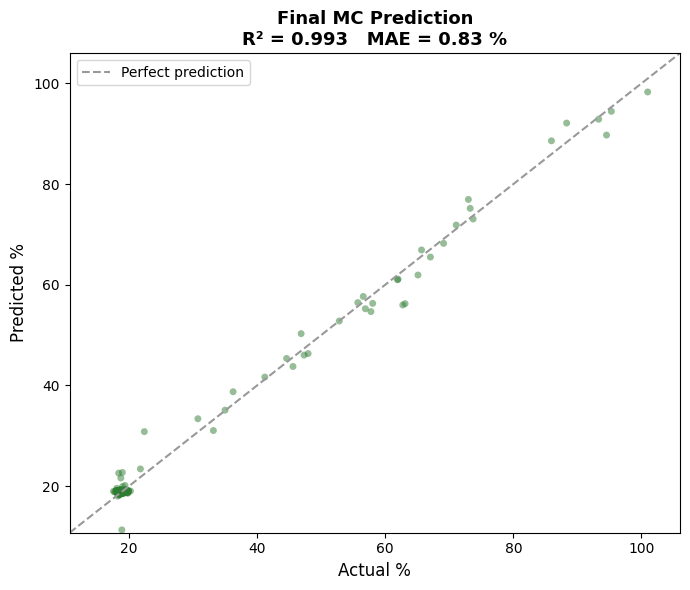

Saved: /content/KilnDrying/plots/pred_MC.png


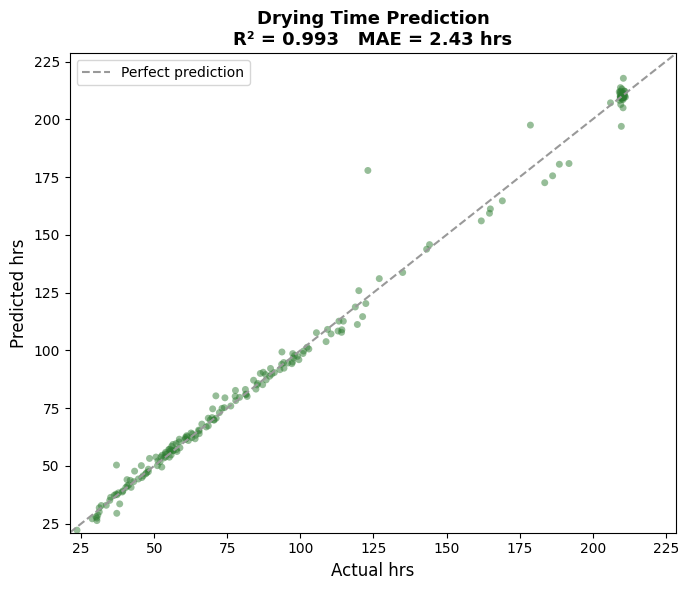

Saved: /content/KilnDrying/plots/pred_time.png


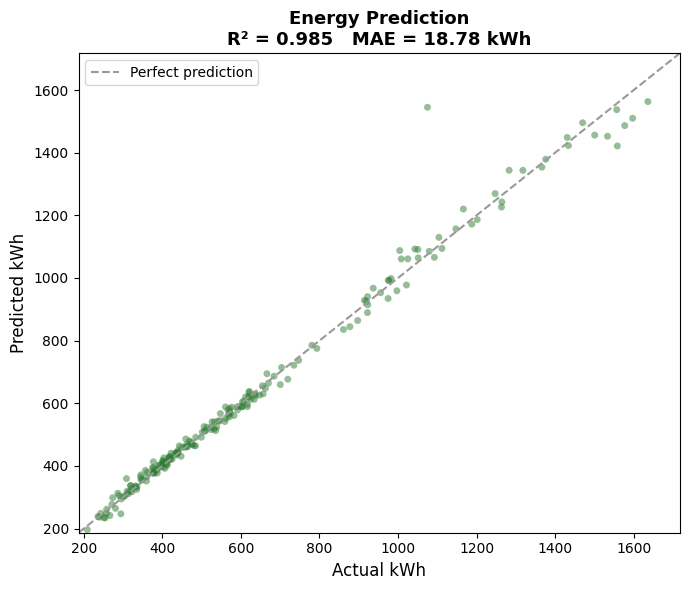

Saved: /content/KilnDrying/plots/pred_energy.png


In [29]:
plot_actual_vs_pred(test_y_MC, pred_y_MC, 'Final MC Prediction', '%', 'pred_MC.png', r2_mc, mae_mc)
plot_actual_vs_pred(test_y_time, pred_y_time, 'Drying Time Prediction', 'hrs', 'pred_time.png', r2_t, mae_t)
plot_actual_vs_pred(test_y_energy, pred_y_energy, 'Energy Prediction', 'kWh', 'pred_energy.png', r2_e, mae_e)

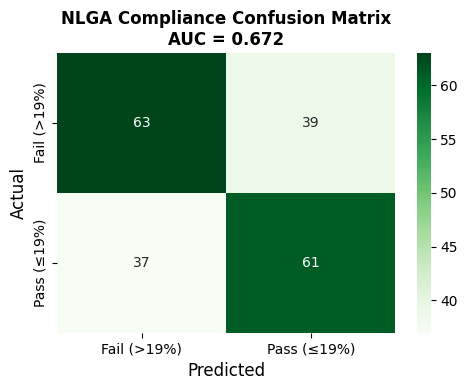

In [30]:
# generate confusion matric of NLGA class
fig, ax = plt.subplots(figsize=(5, 4))
cm = confusion_matrix(test_y_nlga, pred_y_nlga)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Fail (>19%)', 'Pass (≤19%)'],
            yticklabels=['Fail (>19%)', 'Pass (≤19%)'])
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'NLGA Compliance Confusion Matrix\nAUC = {auc:.3f}',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig(f'{PLOTS_DIR}/confusion_matrix.png', dpi=150)
plt.close()

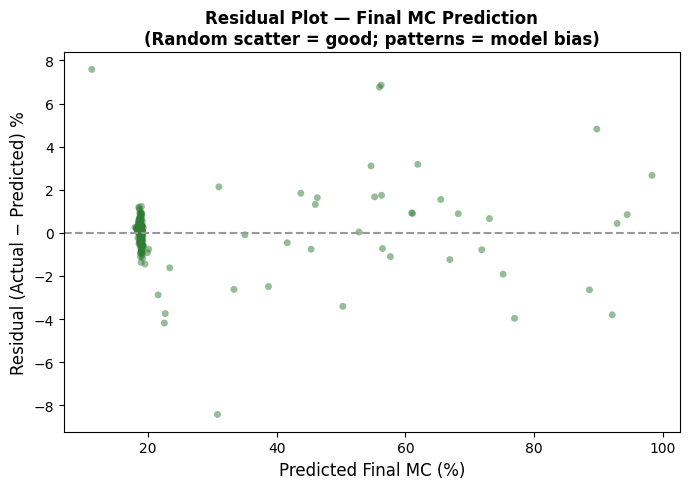

In [32]:
# Residuals plot for primary target : MC, Moisture Control
residuals = test_y_MC - pred_y_MC # difference between predicted MC and actual MC
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(pred_y_MC, residuals, alpha=0.5, s=25, color='#2E7D32', edgecolors='none')
ax.axhline(0, color='#999', linestyle='--', linewidth=1.5)
ax.set_xlabel('Predicted Final MC (%)', fontsize=12)
ax.set_ylabel('Residual (Actual − Predicted) %', fontsize=12)
ax.set_title('Residual Plot — Final MC Prediction\n(Random scatter = good; patterns = model bias)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{PLOTS_DIR}/residuals_MC.png', dpi=150)
plt.show()
plt.close()

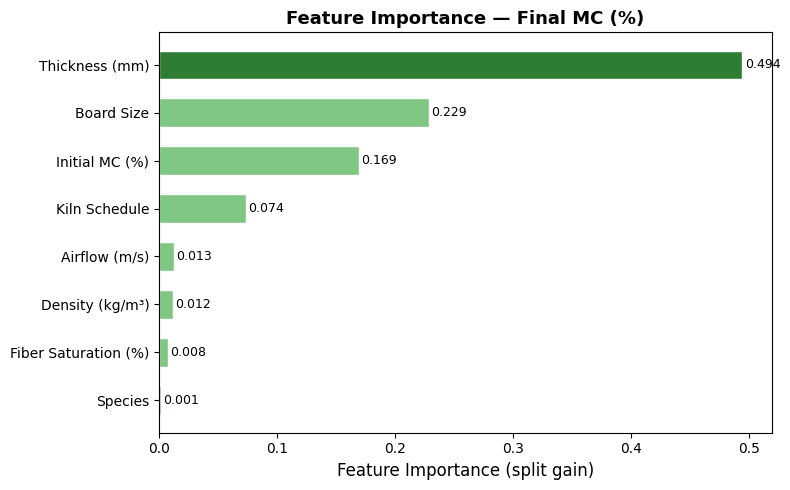

    Saved: /content/KilnDrying/plots/fi_MC.png


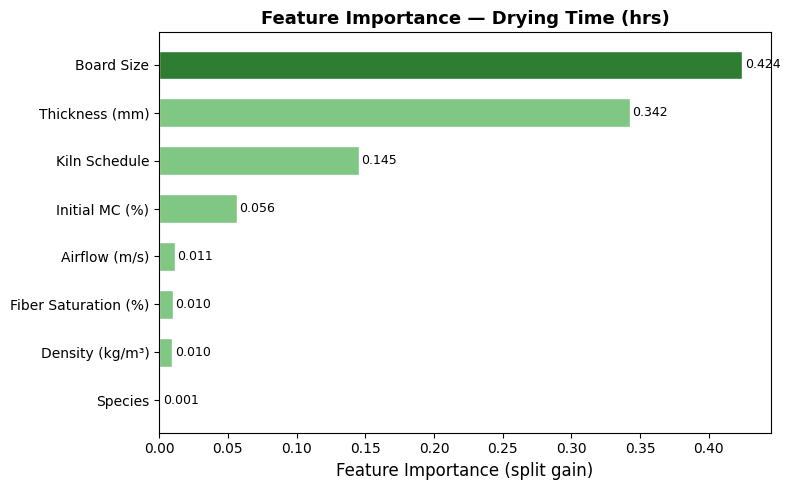

    Saved: /content/KilnDrying/plots/fi_time.png


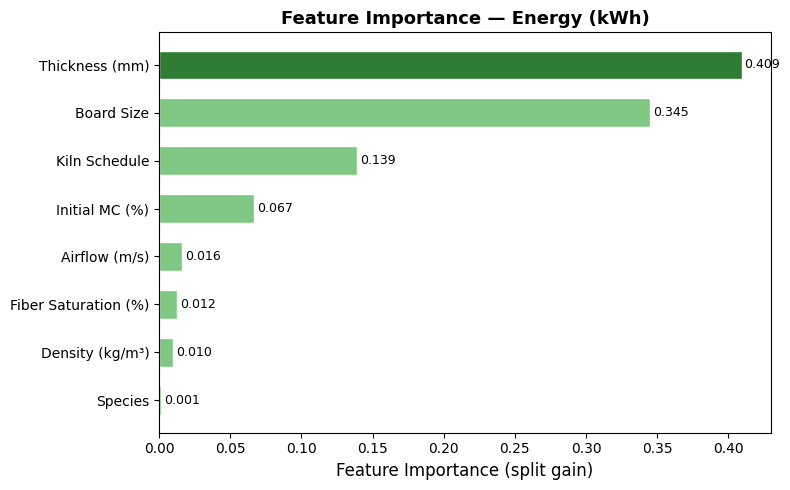

    Saved: /content/KilnDrying/plots/fi_energy.png


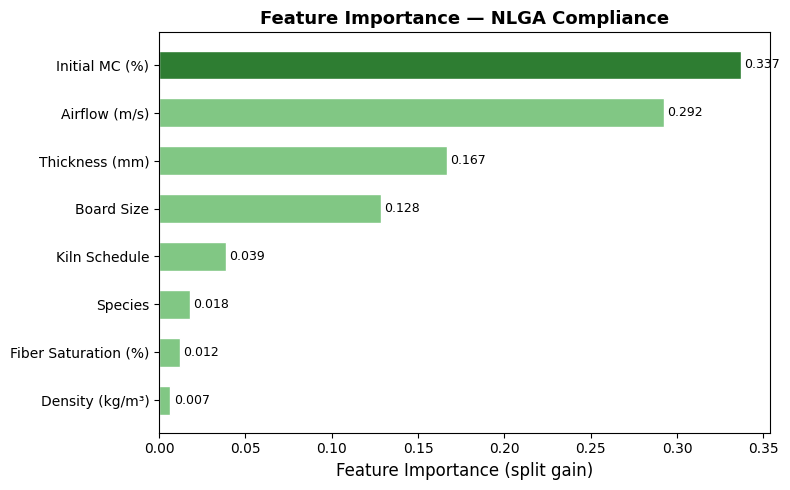

    Saved: /content/KilnDrying/plots/fi_nlga.png


In [39]:
def plot_feature_importance(model, title, filename):
    imp    = model.feature_importances_
    idx    = np.argsort(imp)
    colors = ['#2E7D32' if i == idx[-1] else '#81C784' for i in idx]

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh([FEATURE_LABELS[i] for i in idx], imp[idx],
                   color=colors, edgecolor='white', height=0.6)
    ax.set_xlabel('Feature Importance (split gain)', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    # Add value labels
    for bar, val in zip(bars, imp[idx]):
        ax.text(val + 0.002, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/{filename}', dpi=150)
    plt.show()
    plt.close()
    print(f"    Saved: {PLOTS_DIR}/{filename}")

plot_feature_importance(model_MC, 'Feature Importance — Final MC (%)', 'fi_MC.png')
plot_feature_importance(model_time, 'Feature Importance — Drying Time (hrs)', 'fi_time.png')
plot_feature_importance(model_energy, 'Feature Importance — Energy (kWh)', 'fi_energy.png')
plot_feature_importance(model_nlga, 'Feature Importance — NLGA Compliance', 'fi_nlga.png')